## Imports

In [1]:
import leafmap
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import json
import tomllib
from shapely import wkt
import cv2
MAIN_CSV_PATH = "xBD_WUI_Analysis.csv"
CONFIG_FILE_PATH = "config.toml"

In [40]:
import matplotlib.pyplot as plt
plt.close('all')          # closes all live figures
%matplotlib inline       

## Loading xBD Data 

In [20]:
with open(CONFIG_FILE_PATH, "rb") as f:
    data = tomllib.load(f)
data['datapaths']['xBD_images_path']

'xBD_Dataset/fires/'

In [51]:
image_path = f"{data['datapaths']['data_root']}{data['datapaths']['xBD_images_path']}"
fire_name = "santa-rosa"
fire_type = "wildfire"
pic_number = "0014"
pre_image_f = f"{image_path}{fire_name}/images/{fire_name}-{fire_type}_0000{pic_number}_pre_disaster.tif"
post_image_f = f"{image_path}{fire_name}/images/{fire_name}-{fire_type}_0000{pic_number}_post_disaster.tif"
pre_label_f = f"{image_path}{fire_name}/labels/{fire_name}-{fire_type}_0000{pic_number}_pre_disaster.json"
post_label_f = f"{image_path}{fire_name}/labels/{fire_name}-{fire_type}_0000{pic_number}_post_disaster.json"
print(pre_image_f)

pre_image = rasterio.open(pre_image_f)
post_image = rasterio.open(post_image_f)

pre_image_data = pre_image.read([1,2,3])
pre_image_data = pre_image_data.transpose(1,2,0)
post_image_data = post_image.read([1,2,3])
post_image_data = post_image_data.transpose(1,2,0)

with open(pre_label_f, 'r') as f:
    pre_label_data = json.load(f)

with open(post_label_f, 'r') as f:
    post_label_data = json.load(f)

/Users/abdullah/OneDrive - King's College London/Datasets/WUI_Imagery/xBD_Dataset/fires/santa-rosa/images/santa-rosa-wildfire_00000014_pre_disaster.tif


In [12]:
def inspect_tif(path):

    with rasterio.open(path) as src:
        temp_src = src
        print(f"\n📂 Inspecting: {path}")
        print("Shape (height, width):", (src.height, src.width))
        print("Number of bands:", src.count)
        res_x, res_y = src.res
        print("Pixel size (X):", res_x)
        print("Pixel size (Y):", res_y)
        print("CRS:", src.crs)
        print("Affine Transform:", src.transform)
        print("Band order and descriptions:")
        print()

        for i in range(1, src.count + 1):
            desc = src.descriptions[i-1] or f"Band {i}"
            dtype = src.dtypes[i-1]
            stats = src.read(i).min(), src.read(i).max()
            shape = src.read(i).shape
            print(f"  - Band {i}: {desc}, dtype: {dtype}, min-max: {stats}, shape: {shape}")

In [9]:
inspect_tif(pre_image_f)

<open DatasetReader name='../fires/woolsey/images/woolsey-fire_00000723_pre_disaster.tif' mode='r'>

📂 Inspecting: ../fires/woolsey/images/woolsey-fire_00000723_pre_disaster.tif
Shape (height, width): (1024, 1024)
Number of bands: 3
Pixel size (X): 4.577744945616114e-06
Pixel size (Y): 4.577744945616114e-06
CRS: EPSG:4326
Affine Transform: | 0.00, 0.00,-118.83|
| 0.00,-0.00, 34.04|
| 0.00, 0.00, 1.00|
Band order and descriptions:

  - Band 1: Band 1, dtype: int16, min-max: (np.int16(0), np.int16(237)), shape: (1024, 1024)
  - Band 2: Band 2, dtype: int16, min-max: (np.int16(0), np.int16(232)), shape: (1024, 1024)
  - Band 3: Band 3, dtype: int16, min-max: (np.int16(0), np.int16(225)), shape: (1024, 1024)


In [4]:
import rasterio
import numpy as np

def normalize_to_uint8_per_band(image_path, export=False, export_path="norm_img.tif"):
    """
    Normalizes a multi-band image to 0–255 per band and converts to uint8.
    Expects a path to a .tif file.
    If export=True, saves normalized image to a GeoTIFF at `export_path`.
    Returns: normalized image (H, W, C) as uint8
    """

    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # shape: (C, H, W)
        meta = src.meta.copy()

    # Transpose to (H, W, C)
    if image.shape[0] in [1, 2, 3, 4, 5]:  # (C, H, W) → (H, W, C)
        image = np.transpose(image, (1, 2, 0))

    norm_image = np.zeros_like(image, dtype=np.uint8)

    for i in range(image.shape[2]):
        band = image[:, :, i].astype(np.float32)
        band -= band.min()
        if band.max() > 0:
            band /= band.max()
        band *= 255
        norm_image[:, :, i] = band.astype(np.uint8)

    if export:
        # Update metadata after we're sure norm_image is final
        meta.update({
            'count': norm_image.shape[2],
            'dtype': 'uint8'
        })

        meta.update({'nodata': 0})

        # Transpose back to (C, H, W) for writing
        norm_image_raster = norm_image.transpose(2, 0, 1)

        with rasterio.open(export_path, 'w', **meta) as dst:
            dst.write(norm_image_raster)

    return norm_image


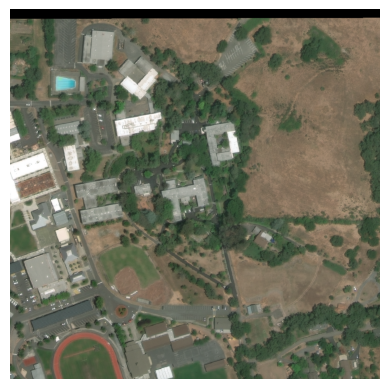

In [52]:
norm_pre = normalize_to_uint8_per_band(pre_image_f, export=False)
plt.imshow(norm_pre)
plt.axis("off")
plt.show()

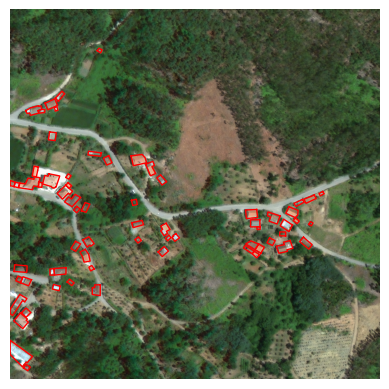

In [44]:
# Example: draw the first structure
poly = wkt.loads(pre_label_data['features']['xy'][0]['wkt'])

# Plot
fig, ax = plt.subplots()
ax.imshow(pre_image_data)  # your loaded and transposed image

for feature in pre_label_data['features']['xy']:
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    ax.plot(x, y, color='red', linewidth=1)

plt.axis('off')
plt.show()


In [22]:
with open(post_label_f, "r") as f:
        lab_data = json.load(f)

In [23]:
lab_data

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
     'subtype': 'no-damage',
     'uid': 'bad8a0d8-e318-4ebc-9f74-5339b3be49e0'},
    'wkt': 'POLYGON ((-118.8292752322299 34.03100322938273, -118.8292742674379 34.03102166882412, -118.8293517600557 34.03103063620765, -118.8294199095425 34.03104613453944, -118.8294279604373 34.03100393438884, -118.829456147512 34.03100564554433, -118.8294538521608 34.03101793094164, -118.829488503599 34.03102274185757, -118.8294785964615 34.03106787955938, -118.8295472826746 34.03107857586947, -118.8295340809195 34.03111925470098, -118.8296316510444 34.03113431503398, -118.8296146490004 34.03119657556697, -118.8295739990563 34.03119057001001, -118.8295647605339 34.0312370491436, -118.829454421613 34.03122324411869, -118.8294598233931 34.03120665119011, -118.8294732659537 34.03120698379029, -118.8294801863074 34.0311717250748, -118.8294596133921 34.03117323389628, -118.8294357077688 34.03117619262683, -118.8293886403658 34.03116821658

## Cloud Detection

In [13]:
pre_image_data

array([[[ 92,  94,  73],
        [ 97,  98,  76],
        [106, 108,  85],
        ...,
        [ 57,  71,  49],
        [ 62,  76,  54],
        [ 60,  73,  53]],

       [[111, 110,  86],
        [114, 114,  89],
        [112, 112,  88],
        ...,
        [ 56,  69,  47],
        [ 55,  67,  47],
        [ 49,  60,  43]],

       [[106, 104,  81],
        [118, 116,  92],
        [116, 115,  92],
        ...,
        [ 45,  55,  38],
        [ 40,  49,  34],
        [ 38,  46,  33]],

       ...,

       [[ 72,  89,  57],
        [ 71,  91,  58],
        [ 71,  89,  57],
        ...,
        [ 67,  84,  55],
        [ 65,  81,  50],
        [ 50,  63,  38]],

       [[ 72,  89,  57],
        [ 70,  87,  56],
        [ 72,  89,  58],
        ...,
        [ 54,  68,  42],
        [ 50,  63,  38],
        [ 48,  61,  37]],

       [[ 65,  79,  51],
        [ 62,  76,  49],
        [ 69,  84,  54],
        ...,
        [ 43,  55,  34],
        [ 40,  51,  31],
        [ 46,  59,  35]]

In [11]:
R, G, B = norm_pre[...,0], norm_pre[...,1], norm_pre[...,2]
hsv = cv2.cvtColor(norm_pre, cv2.COLOR_RGB2HSV)
H, S, V = cv2.split(hsv)
black_mask = (norm_pre[...,0] > 0) | (norm_pre[...,1] > 0) | (norm_pre[...,2] > 0)
print(V[black_mask].mean())
print(H[black_mask].mean())

64.84554195404053
42.3922004699707


In [71]:
# --- Cloud candidates ---
# Bright
bright = V > 200  # try 210–235 depending on exposure

# White-ish: channels similar
whiteish = (np.abs(R-G) < 20) | (np.abs(R-B) < 20) | (np.abs(G-B) < 20)

# Blue-ish haze: blue noticeably higher
blueish = (B.astype(int) - R.astype(int) > 10) & (B.astype(int) - G.astype(int) > 10)

cloud_mask = bright & (whiteish | blueish)

In [ ]:
whiteness = (np.abs(R-G) + np.abs(R-B) + np.abs(G-B))
whiteness

np.float64(38.91111183166504)

In [41]:
total = norm_pre.shape[0] * norm_pre.shape[1]
cloud_cov = cloud_mask.sum() / total
cloud_mask.sum()

np.int64(1103)

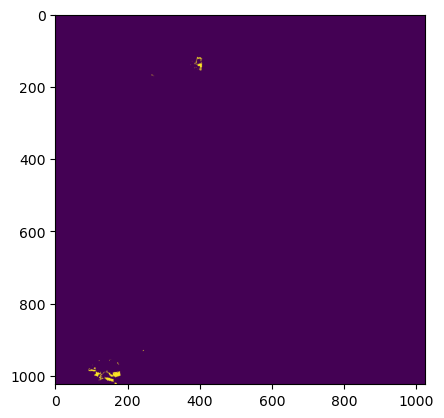

In [42]:
plt.imshow(cloud_mask)

In [16]:
import pandas as pd

CSV = "xBD_WUI_Analysis.csv"
df_q = pd.read_csv(CSV)
df_q.columns

Index(['scene_id', 'fire_name', 'pre_image_path', 'post_image_path',
       'post_label_path', 'polygon_path', 'n_structures_total',
       'n_major_or_destroyed', 'segmented', 'n_polygons', 'pct_black',
       'pct_segmented', 'classified', 'classification_mode',
       'date_time_segmentation', 'date_time_classification'],
      dtype='object')

In [18]:
# keeps NaNs intact
df_q['pre_image_path'] = df_q['pre_image_path'].str.replace("../fires/", "", regex=False)
df_q['post_image_path'] = df_q['post_image_path'].str.replace("../fires/", "", regex=False)
df_q['post_label_path'] = df_q['post_label_path'].str.replace("../fires/", "", regex=False)
df_q['polygon_path'] = df_q['polygon_path'].str.replace("Analysed_Images/", "", regex=False)


In [25]:
df_q['too_cloudy'] = False

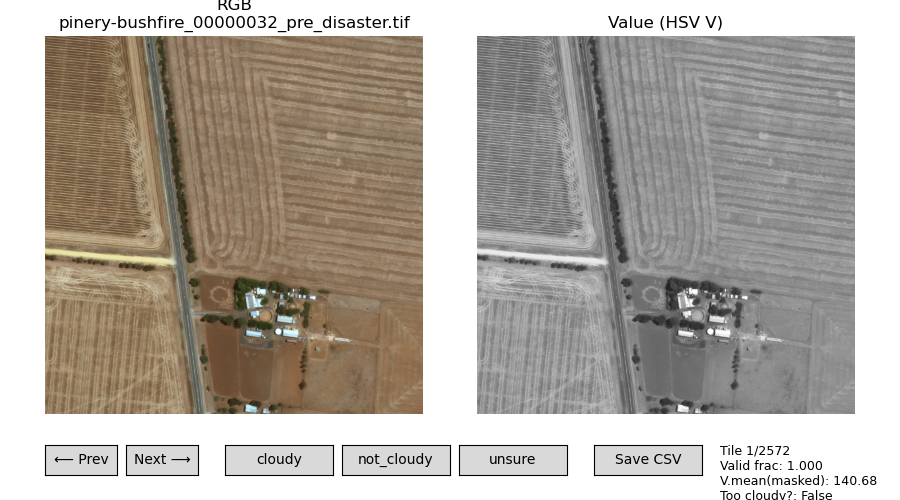

Ready. Found 2572 image(s) in: /Users/abdullah/OneDrive - King's College London/Datasets/WUI_Imagery/xBD_Dataset/fires//woolsey/images
CSV will be saved/updated at: vhr_cloud_labels.csv


In [26]:
# VHR tile reviewer with pure Matplotlib widgets (no ipywidgets required).
# - Flip through images
# - See RGB and Value (HSV V) side-by-side
# - See masked stats (V.mean over non-black)
# - Label each tile as "cloudy", "not_cloudy", or "unsure"
# - Save a CSV to /mnt/data/vhr_cloud_labels.csv
#
# INSTRUCTIONS
# 1) Set IMAGE_DIR to your folder of images.
# 2) Run this cell. An interactive Matplotlib window will appear in the notebook output.
# 3) Use the on-figure buttons:
#       [Prev], [Next], [cloudy], [not_cloudy], [unsure], [Save CSV]
#    You can also use keyboard: Left/Right arrows to navigate, c/n/u to set labels.
# 4) The current CSV path is printed at the end; click the link after saving.
#
# NOTE: Works best in the default notebook renderer. If you don't see the buttons,
#       try running:  %matplotlib notebook  (not needed here by default).

import os
import glob
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, RadioButtons
from pathlib import Path

IMAGE_DIR = image_path+"/woolsey/images"
PATTERNS = ["*pre_disaster.tif"]
CSV_PATH = "vhr_cloud_labels.csv"
BLACK_THRESH = 5  # per-channel threshold for non-black mask
CSV = Path("xBD_WUI_Analysis.csv")

# -----------------------
# Discover files
# -----------------------
files = df_q['pre_image_path'].tolist()
#for pat in PATTERNS:
#    files.extend(glob.glob(os.path.join(IMAGE_DIR, pat)))
#files = sorted(files)

# -----------------------
# Helpers
# -----------------------
def load_rgb(path):
    return (rasterio.open(path).read([1, 2, 3]).transpose(1, 2, 0)).astype(np.uint8)

def rgb_to_v(rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)
    return V

def nonblack_mask(rgb, thr=BLACK_THRESH):
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    return (r > thr) | (g > thr) | (b > thr)

def masked_mean(arr, mask):
    x = arr[mask]
    return float(x.mean()) if x.size else float("nan")

# -----------------------
# DataFrame (persist/resume)
# -----------------------
# cols = ["filename", "v_mean_masked", "valid_frac", "label"]
# df = pd.DataFrame({"filename": files})
# for c in cols[1:]:
#     df[c] = np.nan

# if os.path.exists(CSV_PATH):
#     try:
#         prev = pd.read_csv(CSV_PATH)
#         df = df.merge(prev[cols], on="filename", how="left", suffixes=("", "_prev"))
#         for c in cols[1:]:
#             df[c] = df[c].combine_first(df.get(f"{c}_prev"))
#         drop_cols = [c for c in df.columns if c.endswith("_prev")]
#         df.drop(columns=drop_cols, inplace=True)
#     except Exception as e:
#         print("Warning: could not read previous CSV:", e)

# # Always write an initial CSV so the path exists
# df[cols].to_csv(CSV_PATH, index=False)

# -----------------------
# UI State
# -----------------------
state = {"i": 0}

fig = plt.figure(figsize=(9, 5))
ax_rgb = fig.add_axes([0.05, 0.15, 0.42, 0.8])
ax_v   = fig.add_axes([0.53, 0.15, 0.42, 0.8])

# Buttons row
ax_prev = fig.add_axes([0.05, 0.05, 0.08, 0.06])
ax_next = fig.add_axes([0.14, 0.05, 0.08, 0.06])
ax_cloudy = fig.add_axes([0.25, 0.05, 0.12, 0.06])
ax_not = fig.add_axes([0.38, 0.05, 0.12, 0.06])
ax_unsure = fig.add_axes([0.51, 0.05, 0.12, 0.06])
ax_save = fig.add_axes([0.66, 0.05, 0.12, 0.06])

btn_prev = Button(ax_prev, "⟵ Prev")
btn_next = Button(ax_next, "Next ⟶")
btn_cloudy = Button(ax_cloudy, "cloudy")
btn_not = Button(ax_not, "not_cloudy")
btn_unsure = Button(ax_unsure, "unsure")
btn_save = Button(ax_save, "Save CSV")

# Info text area
ax_info = fig.add_axes([0.80, 0.02, 0.15, 0.10])
ax_info.axis("off")
info_text = ax_info.text(0, 0.9, "", va="top", fontsize=9)

def render():
    ax_rgb.clear()
    ax_v.clear()

    path = image_path + files[state["i"]]
    rgb = load_rgb(path)
    V = rgb_to_v(rgb)
    mask = nonblack_mask(rgb, thr=BLACK_THRESH)

    vmean = masked_mean(V, mask)
    valid_frac = float(mask.mean())

    # Update df
    row = df_q["pre_image_path"] == files[state["i"]]
    #df.loc[row, "v_mean_masked"] = vmean
    #df.loc[row, "valid_frac"] = valid_frac

    # Show images
    ax_rgb.imshow(rgb)
    ax_rgb.set_title(f"RGB\n{os.path.basename(path)}")
    ax_rgb.axis("off")

    ax_v.imshow(V, cmap="gray", vmin=0, vmax=255)
    ax_v.set_title("Value (HSV V)")
    ax_v.axis("off")

    # Info
    label_val = df_q.loc[row, "too_cloudy"].values[0]

    info_text.set_text(
        f"Tile {state['i']+1}/{len(files)}\n"
        f"Valid frac: {valid_frac:.3f}\n"
        f"V.mean(masked): {vmean:.2f}\n"
        f"Too cloudy?: {label_val}"
    )

    fig.canvas.draw_idle()

def set_label(lbl):
    path = files[state["i"]]
    df_q.loc[df_q["pre_image_path"] == path, "too_cloudy"] = lbl
    render()

def go(delta):
    state["i"] = int(np.clip(state["i"] + delta, 0, len(files) - 1))
    render()

def save_csv(event=None):
    tmp = CSV.with_suffix(".csv.tmp")
    df_q.to_csv(tmp, index=False)
    os.replace(tmp, CSV)
    info_text.set_text(info_text.get_text() + "\nSaved CSV ✅")
    fig.canvas.draw_idle()

btn_prev.on_clicked(lambda e: go(-1))
btn_next.on_clicked(lambda e: go(+1))
btn_cloudy.on_clicked(lambda e: set_label(True))
btn_not.on_clicked(lambda e: set_label(False))
btn_unsure.on_clicked(lambda e: set_label(False))
btn_save.on_clicked(save_csv)

def on_key(event):
    if event.key == "left":
        go(-1)
    elif event.key == "right":
        go(+1)
    elif event.key in ("c", "C"):
        set_label(True)
    elif event.key in ("n", "N"):
        set_label(False)
    elif event.key in ("u", "U"):
        set_label(False)
    elif event.key in ("s", "S"):
        save_csv()

fig.canvas.mpl_connect("key_press_event", on_key)

render()
plt.show()

print(f"Ready. Found {len(files)} image(s) in: {IMAGE_DIR}")
print(f"CSV will be saved/updated at: {CSV_PATH}")


In [ ]:
1060

## Plotting

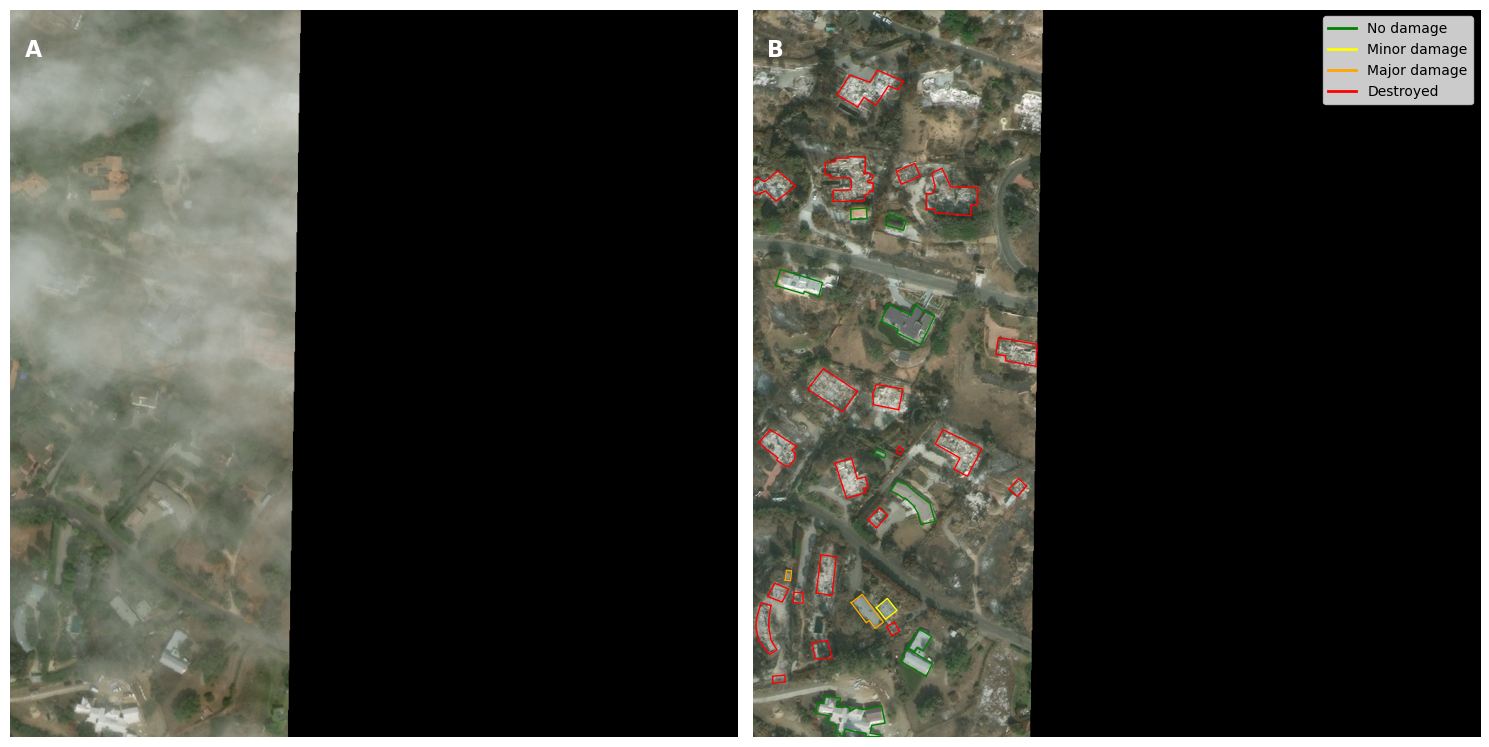

In [24]:
# Define a color map for damage levels
damage_colors = {
    "no-damage": "green",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red"
}

fig, axes = plt.subplots(1, 2, figsize=(15, 8)) # Changed from (1, 3) to (1, 2)

axes[0].imshow(pre_image_data)
axes[0].axis('off')
axes[0].text(
        0.02, 0.96, "A",                # (x, y) in axes fraction coordinates
        transform=axes[0].transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )


ax = axes[1]

ax.imshow(post_image_data)

for feature in post_label_data['features']['xy']:
    damage_level = feature['properties'].get('subtype', 'no-damage')
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    color = damage_colors.get(damage_level, 'gray')  # fallback if unknown
    ax.plot(x, y, color=color, linewidth=1)

# Optional: add legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=label.replace('-', ' ').capitalize())
    for label, color in damage_colors.items()
]

ax.legend(handles=legend_elements)
ax.axis('off')
ax.text(
        0.02, 0.96, "B",                # (x, y) in axes fraction coordinates
        transform=ax.transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )


#axes[2].imshow(ann_img_data)
#axes[2].axis('off')
#axes[2].text(
#        0.02, 0.96, "C",                # (x, y) in axes fraction coordinates
#        transform=axes[2].transAxes,               # makes coordinates relative to axes (0–1)
#        fontsize=16, fontweight='bold',
#        va='top', ha='left', color='white'    # align top-left
#    )


plt.tight_layout()
#plt.savefig("xBD_Analysis.png", dpi=300, bbox_inches="tight")
plt.show()


## Processing Candidate Images and CSV

In [385]:
import json
from pathlib import Path
import pandas as pd
import os

In [112]:
ROOT = Path("../fires")  # change if needed
GLOB_PATTERNS = [
    "**/labels/*_post_disaster.json",  # find post labels everywhere under ROOT
]

CSV_OUT = Path("xBD_WUI_Analysis.csv")

# Columns to keep in the master index (pre-fill some; update later in your pipeline)
INDEX_COLUMNS = [
    "scene_id",
    "fire_name",
    "pre_image_path",
    "post_image_path",
    "post_label_path",
    "gpkg_path",
    "n_structures_total",
    "n_major_or_destroyed",
    "segmented",
    "n_polygons",
    "pct_black",
    "pct_segmented",
    "classified",
    "classification_mode",
]

DAMAGE_HARD = {"major-damage", "destroyed"}

In [394]:
def parse_label_counts(json_path: Path, quick=False):
    """Return (total_buildings, major_or_destroyed) from an xBD post label JSON."""
    with open(json_path, "r") as f:
        data = json.load(f)

    feats = data.get("features", {}).get("xy", [])

    if quick:
        return len(feats)

    total = 0
    hard = 0
    for feat in feats:
        props = (feat or {}).get("properties", {})
        if props.get("feature_type") != "building":
            continue
        total += 1
        subtype = props.get("subtype", "").lower()
        if subtype in DAMAGE_HARD:
            hard += 1
    return total, hard

In [62]:
total, hard = parse_label_counts(post_label_f)

In [400]:
def infer_paths_from_label(label_path: Path):
    """
    From a *_post_disaster.json, infer:
      - fire_name (parent of labels/)
      - scene_id (stem without extension, or nicer shortened id)
      - pre/post image paths
      - default gpkg path you plan to write later
    """
    fire_name = label_path.parents[1].name  # e.g., 'santa-rosa'
    stem = label_path.stem                  # e.g., 'santa-rosa-wildfire_0000XXXX_post_disaster'
    # Derive corresponding pre/post image filenames by replacing suffix
    post_img = label_path.parents[1] / "images" / (stem.replace("_post_disaster", "_post_disaster") + ".tif")
    pre_img  = label_path.parents[1] / "images" / (stem.replace("_post_disaster", "_pre_disaster") + ".tif")

    # Scene id: fire + number chunk (customize if you want)
    # Try to keep something like 'santa-rosa_0000XXXX'
    parts = stem.split("_")
    number = parts[1][4:]
    scene_id = f"{fire_name}_{number}"

    gpkg_path = Path("./Analysed_Images") / f"{scene_id}_polygons.pkl"
    return fire_name, scene_id, pre_img, post_img, gpkg_path

In [396]:
def find_post_label_files(root: Path):
    files = []
    for pat in GLOB_PATTERNS:
        files.extend(root.glob(pat))
    return sorted(files)

In [397]:
ROOT = Path("../fires")  # change if needed
GLOB_PATTERNS = [
    "**/labels/*_post_disaster.json",  # find post labels everywhere under ROOT
]
CSV_OUT = Path("xBD_WUI_Analysis.csv")
DAMAGE_HARD = {"major-damage", "destroyed"}

In [398]:
label_files = find_post_label_files(ROOT)

In [399]:
str(label_files[0])

'../fires/pinery/labels/pinery-bushfire_00000000_post_disaster.json'

In [84]:
fire_name, scene_id, pre_img, post_img, gpkg_path = infer_paths_from_label(label_files[21])

In [85]:
post_img

PosixPath('../fires/pinery/images/pinery-bushfire_00000021_post_disaster.tif')

In [68]:
gpkg_path

PosixPath('Analysed_Images/pinery_0021_polygons.gpkg')

In [401]:
def generate_candidates(min_buildings=5, min_hard=2):
    rows = []
    per_fire_counts = {}   # {fire_name: count_of_candidates}

    label_files = find_post_label_files(ROOT)
    for lbl in label_files:
        try:
            total, hard = parse_label_counts(lbl)
        except Exception as e:
            print(f"[WARN] Failed parsing {lbl}: {e}")
            continue

        # Apply your filter
        if total >= min_buildings and hard >= min_hard:
            fire_name, scene_id, pre_img, post_img, gpkg_path = infer_paths_from_label(lbl)

            # Track per-fire counts
            per_fire_counts[fire_name] = per_fire_counts.get(fire_name, 0) + 1

            # Build row with placeholders for fields you’ll fill later
            row = {
                "scene_id": scene_id,
                "fire_name": fire_name,
                "pre_image_path": str(pre_img),
                "post_image_path": str(post_img),
                "post_label_path": str(lbl),
                "polygon_path": str(gpkg_path),
                "n_structures_total": total,
                "n_major_or_destroyed": hard,
                "segmented": False,
                "n_polygons": None,
                "pct_black": None,
                "pct_segmented": None,
                "classified": False,
                "classification_mode": None,
                "date_time_segmentation": None,
                "date_time_classification": None,
            }
            rows.append(row)

    # Create dataframe in your desired column order
    #df = pd.DataFrame(rows, columns=INDEX_COLUMNS)

    # Save CSV (atomic write)
    #CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
    #tmp = CSV_OUT.with_suffix(".csv.tmp")
    #df.to_csv(tmp, index=False)
    #tmp.replace(CSV_OUT)

    # Print per-fire summary
    if per_fire_counts:
        print("\nCandidates per fire (>= {min_buildings} buildings & >= {min_hard} major/destroyed):")
        for k in sorted(per_fire_counts):
            print(f"  {k}: {per_fire_counts[k]}")
        print(f"\nTotal candidates: {sum(per_fire_counts.values())}")
        print(f"CSV written: {CSV_OUT}")
    else:
        print("No candidates matched the criteria.")

    return rows


In [422]:
all_rows = generate_candidates(min_buildings=1, min_hard=0)


Candidates per fire (>= {min_buildings} buildings & >= {min_hard} major/destroyed):
  pinery: 471
  portugal: 975
  santa-rosa: 368
  socal: 356
  woolsey: 402

Total candidates: 2572
CSV written: xBD_WUI_Analysis.csv


In [423]:
all_rows[0]["scene_id"]

'pinery_0001'

In [430]:
CSV = Path("xBD_WUI_Analysis.csv")
df_q = pd.read_csv(CSV)

In [424]:
final_list = []
for i in range(len(all_rows)):
    
    l = df_q["scene_id"].eq(all_rows[i]["scene_id"])
    row = df_q.loc[l]
    
    if(len(row) == 0):
        final_list.append(all_rows[i])

final_list

[{'scene_id': 'pinery_0001',
  'fire_name': 'pinery',
  'pre_image_path': '../fires/pinery/images/pinery-bushfire_00000001_pre_disaster.tif',
  'post_image_path': '../fires/pinery/images/pinery-bushfire_00000001_post_disaster.tif',
  'post_label_path': '../fires/pinery/labels/pinery-bushfire_00000001_post_disaster.json',
  'polygon_path': 'Analysed_Images/pinery_0001_polygons.pkl',
  'n_structures_total': 1,
  'n_major_or_destroyed': 0,
  'segmented': False,
  'n_polygons': None,
  'pct_black': None,
  'pct_segmented': None,
  'classified': False,
  'classification_mode': None,
  'date_time_segmentation': None,
  'date_time_classification': None},
 {'scene_id': 'pinery_0002',
  'fire_name': 'pinery',
  'pre_image_path': '../fires/pinery/images/pinery-bushfire_00000002_pre_disaster.tif',
  'post_image_path': '../fires/pinery/images/pinery-bushfire_00000002_post_disaster.tif',
  'post_label_path': '../fires/pinery/labels/pinery-bushfire_00000002_post_disaster.json',
  'polygon_path': 'An

In [426]:
other_df = pd.DataFrame(final_list)

In [429]:
final_df = pd.concat([df_q, other_df], ignore_index=True)
tmp = CSV.with_suffix(".csv.tmp")
final_df.to_csv(tmp, index=False)
os.replace(tmp, CSV)

In [ ]:
tmp = CSV.with_suffix(".csv.tmp")
df_q.to_csv(tmp, index=False)
os.replace(tmp, CSV)   # atomic rename on the same filesystem

In [ ]:
import pandas as pd
from pathlib import Path
import os

CSV = Path("xBD_WUI_Analysis.csv")

df = pd.read_csv(CSV)

# Optional: fix dtype if the column came in as string
df["n_major_or_destroyed"] = pd.to_numeric(df["n_major_or_destroyed"], errors="coerce").fillna(0).astype(int)

# 1) Decide the order of fires to cycle through
#    Option A: explicit order (recommended, stable)
fire_order = ["pinery", "santa-rosa", "woolsey", "portugal", "socal"]  # <- put your 5 names here in the order you want

#    Option B: derive order deterministically (comment out A if you prefer this)
# fire_order = (
#     df.groupby("fire_name")["n_major_or_destroyed"]
#       .sum().sort_values(ascending=False)
#       .index.tolist()
# )

# Map fire_name -> ordinal so we can sort later
fire_rank = {name: i for i, name in enumerate(fire_order)}
df["fire_order"] = df["fire_name"].map(fire_rank)

# 2) Sort within each fire by n_major_or_destroyed (desc), then assign position 0,1,2,...
df = (df.sort_values(["fire_name", "n_major_or_destroyed"], ascending=[True, False])
        .assign(pos=lambda x: x.groupby("fire_name").cumcount()))

# 3) Interleave: sort by the round index (pos), then by fire_order
#    (Rows from different fires with the same pos will appear together in fire_order sequence)
df_roundrobin = df.sort_values(["pos", "fire_order"]).drop(columns=["pos", "fire_order"]).reset_index(drop=True)


In [ ]:
tmp = CSV.with_suffix(".csv.tmp")
df_roundrobin.to_csv(tmp, index=False, lineterminator="\n")
os.replace(tmp, CSV)

## Duplicate File Handling

In [ ]:
import hashlib
from pathlib import Path

def file_hash(path, algo="sha256", chunk_size=8192):
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# compute hashes for all tif files
tifs = list(Path("../../xBD_dataset").rglob("*.tif"))
hashes = {p: file_hash(p) for p in tifs}

# find duplicates
from collections import defaultdict
rev = defaultdict(list)
for path, h in hashes.items():
    rev[h].append(path)
duplicates = {h: ps for h, ps in rev.items() if len(ps) > 1}


{'bd7a87f3ee91168f6f3c519cb93dfcd0c81c5e3880bccdbaa3a5443d4e31b4aa': [PosixPath('../../xBD_dataset/WUI_Risk_Analysis/norm_img.tif'), PosixPath('../../xBD_dataset/WUI_Risk_Analysis/woolsey_0723_norm_img.tif')], '14b4135cbced793e32af410915d2783c146d22d00c22853daabb29425dd2ac8d': [PosixPath('../../xBD_dataset/fires/socal/images/socal-fire_00001051_pre_disaster.tif'), PosixPath('../../xBD_dataset/fires/woolsey/images/woolsey-fire_00000740_pre_disaster.tif')], '4e4917ae50e243430e50e77948d0878cb00c995f101fba91069111ec56e3f108': [PosixPath('../../xBD_dataset/fires/socal/images/socal-fire_00000913_pre_disaster.tif'), PosixPath('../../xBD_dataset/fires/woolsey/images/woolsey-fire_00000728_pre_disaster.tif')], '7768f2c781e89ab231aa2b354b7d16557b29bd038c59021885d70d65d724c11b': [PosixPath('../../xBD_dataset/fires/socal/images/socal-fire_00000514_pre_disaster.tif'), PosixPath('../../xBD_dataset/fires/woolsey/images/woolsey-fire_00000706_pre_disaster.tif')], '29be7dd338423c316393ac1cc9924cfb5d70353

In [239]:
from pathlib import Path
from itertools import combinations
import pandas as pd
import re

def _extract_fire_name(p: Path) -> str:
    """Get fire name from a path like .../fires/<FIRE_NAME>/images/..."""
    parts = [x.lower() for x in p.parts]
    if "fires" in parts:
        i = parts.index("fires")
        if i + 1 < len(parts):
            return p.parts[i + 1]
    # fallback: try to read from filename prefix e.g. 'santa-rosa-wildfire_...'
    m = re.match(r"([a-z0-9\-]+)-(wildfire|bushfire|fire)", p.stem.lower())
    return m.group(1) if m else ""

def _extract_phase(p: Path) -> str:
    """Return 'Pre' or 'Post' based on filename."""
    s = p.name.lower()
    if "pre_disaster" in s:
        return "Pre"
    if "post_disaster" in s:
        return "Post"
    return ""  # unknown

def duplicates_to_df(hash_to_paths: dict) -> pd.DataFrame:
    """
    hash_to_paths: dict[str, list[str | Path]]
      e.g. { "<sha256>": ["/path/a.tif", "/path/b.tif", ...], ... }

    Returns DataFrame with columns: image1, image2, fire1, fire2, phase
    (one row per unordered pair in each duplicate group).
    """
    rows = []
    for _, paths in hash_to_paths.items():
        if len(paths) < 2:
            continue
        paths = [Path(p) for p in paths]
        # All files in a duplicate group should share the same phase; take from first
        phase = _extract_phase(paths[0])
        for p1, p2 in combinations(paths, 2):
            rows.append({
                "image1": str(p1),
                "image2": str(p2),
                "fire1":  _extract_fire_name(p1),
                "fire2":  _extract_fire_name(p2),
                "phase":  phase,     # Pre/Post (same for both in xBD)
            })
    df = pd.DataFrame(rows, columns=["image1", "image2", "fire1", "fire2", "phase"])
    return df


In [240]:
dup_df = duplicates_to_df(duplicates)

In [246]:
with open("duplicate_images_df.pkl", "wb") as f:
	pickle.dump(dup_df, f)

In [247]:
with open('duplicate_images_df.pkl', 'rb') as f:
    duplicate_df = pickle.load(f)

In [279]:
def from_image_path_to_label_path(img_path, type="post"):
    label_path = img_path.replace(".tif", ".json")
    label_path = label_path.replace("images", "labels")
    if type == "pre":
        if "post_disaster" in img_path:
            label_path = label_path.replace("post_disaster", "pre_disaster")
    if type == "post":
        if "pre_disaster" in img_path:
            label_path = label_path.replace("pre_disaster", "post_disaster")
    return label_path

In [296]:
label_counts = []
label_counts.append((0,0,0,0))  # dummy for first row

for i in range(len(duplicate_df)):
    if i == 0:
        continue
    total1_pre = parse_label_counts(from_image_path_to_label_path(duplicate_df.iloc[i]["image1"], type="pre"), quick=True)
    total1_post = parse_label_counts(from_image_path_to_label_path(duplicate_df.iloc[i]["image1"]), quick=True)
    total2_pre = parse_label_counts(from_image_path_to_label_path(duplicate_df.iloc[i]["image2"], type="pre"), quick=True)
    total2_post = parse_label_counts(from_image_path_to_label_path(duplicate_df.iloc[i]["image2"]), quick=True)
    label_counts.append((total1_pre, total1_post, total2_pre, total2_post))

In [300]:
parse_label_counts(from_image_path_to_label_path(duplicate_df.iloc[1]["image1"]), quick=True)

4

In [ ]:
label_counts

[(0, 0, 0, 0),
 (4, 4, 4, 4),
 (25, 25, 30, 30),
 (42, 42, 30, 30),
 (4, 4, 1, 1),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (28, 28, 12, 12),
 (12, 12, 14, 14),
 (1, 1, 0, 0),
 (1, 1, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (1, 1, 1, 1),
 (6, 6, 5, 5),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (46, 46, 47, 47),
 (18, 18, 19, 19),
 (27, 27, 31, 31),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (1, 1, 0, 0),
 (10, 10, 13, 13),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (3, 3, 5, 5),
 (6, 6, 5, 5),
 (7, 7, 7, 7),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (0, 0, 0, 0),
 (44, 44, 57, 57),
 (23, 23, 28, 28),
 (0, 0, 0, 0),
 (14, 14, 25, 25),
 (14, 14, 24, 24),
 (0, 0, 0, 0),
 (0, 0, 1, 1),
 (2, 2,

In [ ]:
def read_image(img_path):
    image = rasterio.open(img_path)
    image_data = image.read([1,2,3])
    image_data = image_data.transpose(1,2,0)
    return image_data

In [262]:
def pre_and_post_paths(img_path):
    paths = []
    if "pre_disaster" in img_path:
        post_path = img_path.replace("pre_disaster", "post_disaster")
        paths = [img_path, post_path]
    elif "post_disaster" in img_path:
        pre_path = img_path.replace("post_disaster", "pre_disaster")
        paths = [pre_path, img_path]
    return paths

In [375]:
CSV = Path("xBD_WUI_Analysis.csv")
df_q = pd.read_csv(CSV)

In [389]:
for i in range(len(duplicate_df)):
    if i == 0 or i == 2:
        continue
    pre_tif = pre_and_post_paths(duplicate_df.iloc[i]["image1"])[0].replace("../xBD_dataset/", "")
    if "pinery" in pre_tif:
        break

    l = df_q["pre_image_path"].eq(pre_tif)
    row = df_q.loc[l]
    
    if len(row) != 0:
        idx = df_q.index[l][0]
        df_q.drop(index=idx, inplace=True)

    post_tif = pre_and_post_paths(duplicate_df.iloc[i]["image1"])[1]
    pre_label = from_image_path_to_label_path(duplicate_df.iloc[i]["image1"], type="pre")
    post_label = from_image_path_to_label_path(duplicate_df.iloc[i]["image1"], type="post")

    if Path(pre_tif).exists():
        os.remove(pre_tif)
    if Path(post_tif).exists():
        os.remove(post_tif)
    if Path(pre_label).exists():
        os.remove(pre_label)
    if Path(post_label).exists():
        os.remove(post_label)

In [ ]:
df_q

In [393]:
tmp = "xBD_WUI_Analysis.csv.tmp"
df_q.to_csv(tmp, index=False, lineterminator="\n")
os.replace(tmp, CSV)

In [391]:
count = 0
for i in range(len(duplicate_df)):
    if(Path(duplicate_df.iloc[i]["image1"]).exists()):
        print(duplicate_df.iloc[i]["image1"])
        count += 1
count

../../xBD_dataset/WUI_Risk_Analysis/norm_img.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00001240_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00001023_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000221_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000923_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00001095_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000895_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000971_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000010_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00001026_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000047_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_00000812_post_disaster.tif
../../xBD_dataset/fires/pinery/images/pinery-bushfire_000007

80

In [372]:
index = 807

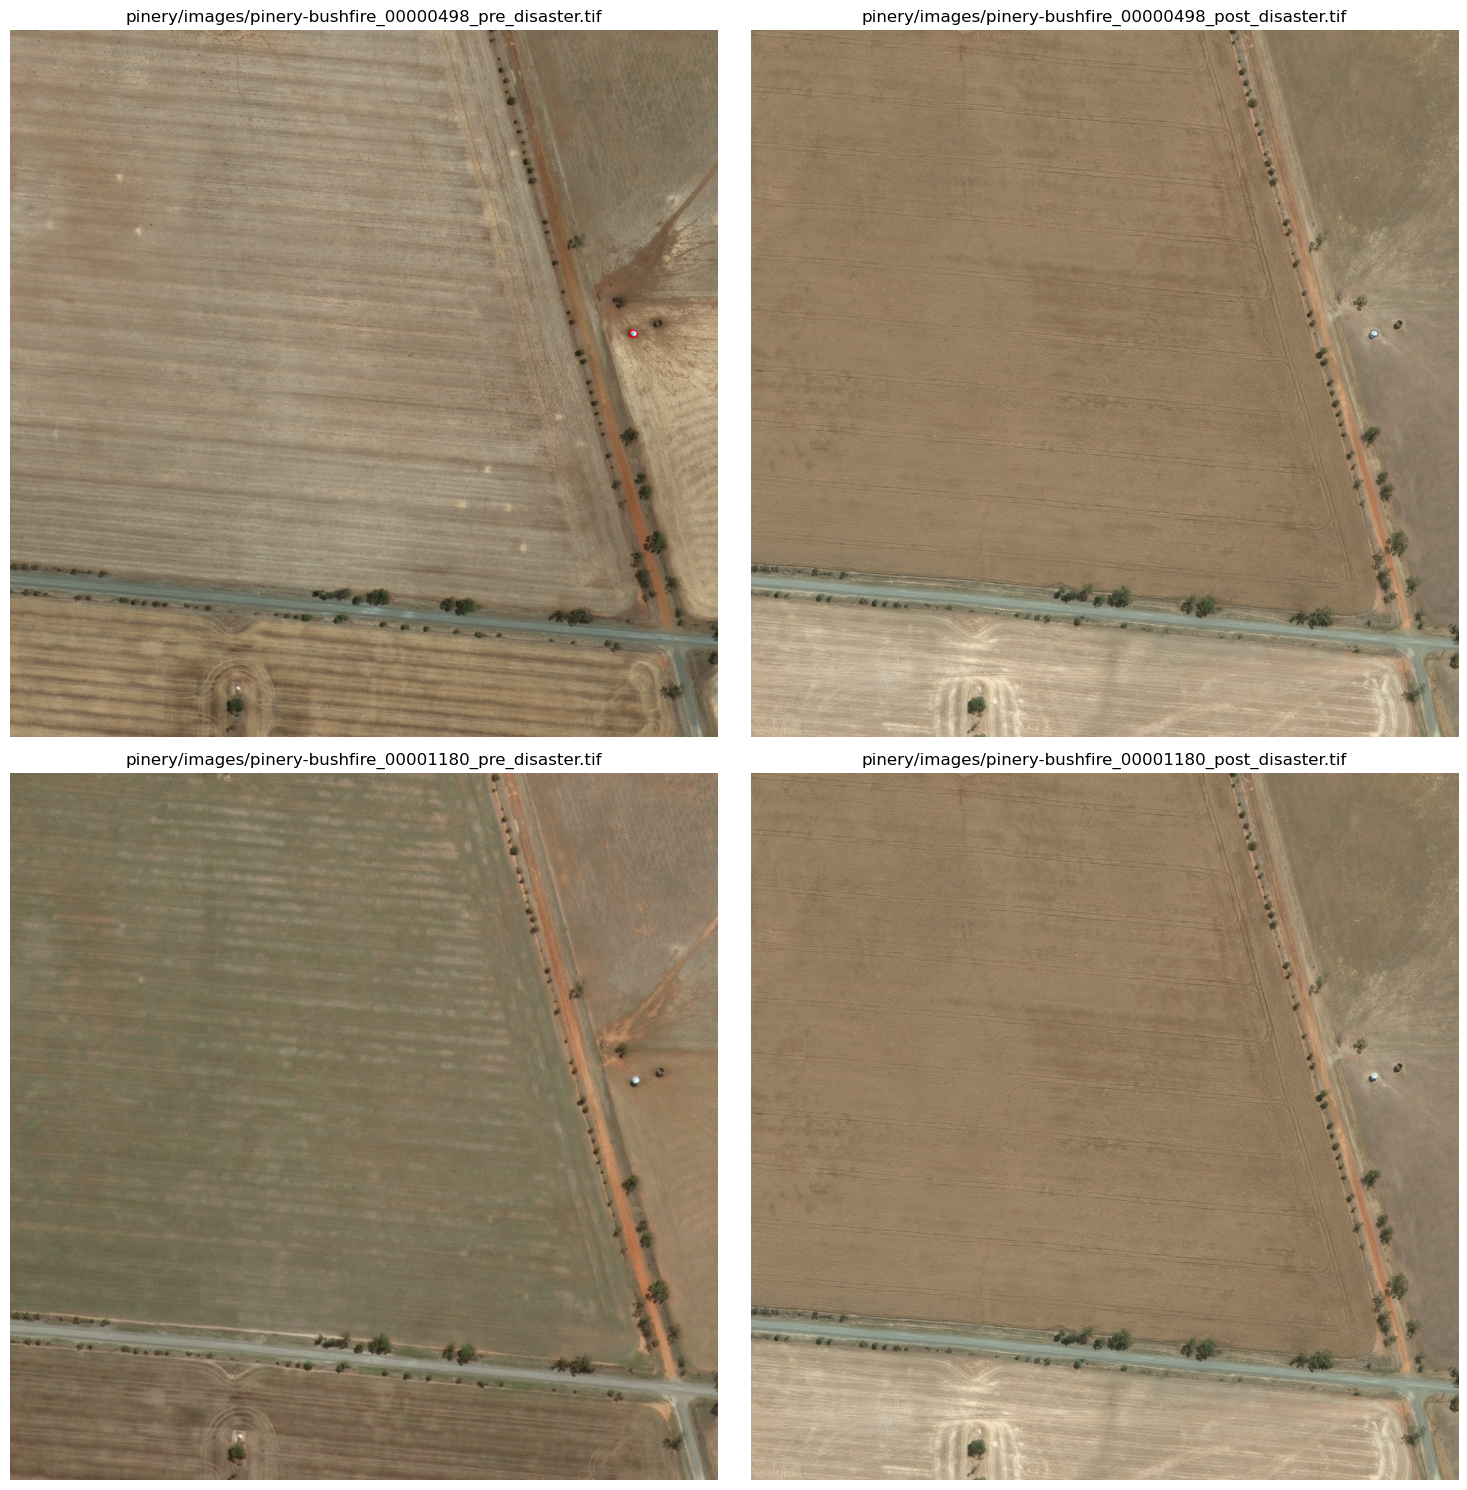

In [373]:
image1_paths = pre_and_post_paths(duplicate_df.iloc[index]["image1"])
image2_paths = pre_and_post_paths(duplicate_df.iloc[index]["image2"])

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0,0].imshow(read_image(image1_paths[0]))
axes[0,0].axis("off")
axes[0,0].set_title(image1_paths[0].replace("../../xBD_dataset/fires/", ""))

with open(from_image_path_to_label_path(image1_paths[0], type="pre"), 'r') as f:
    pre_label_data1 = json.load(f)

if(len(pre_label_data1['features']['xy']) != 0):
    for feature in pre_label_data1['features']['xy']:
        poly = wkt.loads(feature['wkt'])
        x, y = poly.exterior.xy
        axes[0,0].plot(x, y, color='red', linewidth=1)

axes[0,1].imshow(read_image(image1_paths[1]))
axes[0,1].axis("off")
axes[0,1].set_title(image1_paths[1].replace("../../xBD_dataset/fires/", ""))

with open(from_image_path_to_label_path(image1_paths[1], type="post"), 'r') as f:
    post_label_data1 = json.load(f)

if(len(post_label_data1['features']['xy']) != 0):
    for feature in post_label_data1['features']['xy']:
        damage_level = feature['properties'].get('subtype', 'no-damage')
        poly = wkt.loads(feature['wkt'])
        x, y = poly.exterior.xy
        color = damage_colors.get(damage_level, 'gray')  # fallback if unknown
        axes[0,1].plot(x, y, color=color, linewidth=1)

axes[1,0].imshow(read_image(image2_paths[0]))
axes[1,0].axis("off")
axes[1,0].set_title(image2_paths[0].replace("../../xBD_dataset/fires/", ""))

with open(from_image_path_to_label_path(image2_paths[0], type="pre"), 'r') as f:
    pre_label_data2 = json.load(f)

if(len(pre_label_data2['features']['xy']) != 0):
    for feature in pre_label_data2['features']['xy']:
        poly = wkt.loads(feature['wkt'])
        x, y = poly.exterior.xy
        axes[1,0].plot(x, y, color='red', linewidth=1)

axes[1,1].imshow(read_image(image2_paths[1]))
axes[1,1].axis("off")
axes[1,1].set_title(image2_paths[1].replace("../../xBD_dataset/fires/", ""))

with open(from_image_path_to_label_path(image2_paths[1], type="post"), 'r') as f:
    post_label_data2 = json.load(f)

if(len(post_label_data2['features']['xy']) != 0):
    for feature in post_label_data2['features']['xy']:
        damage_level = feature['properties'].get('subtype', 'no-damage')
        poly = wkt.loads(feature['wkt'])
        x, y = poly.exterior.xy
        color = damage_colors.get(damage_level, 'gray')  # fallback if unknown
        axes[1,1].plot(x, y, color=color, linewidth=1)

plt.tight_layout()
plt.show()


In [307]:
post_label_data1['features']['xy']

[{'properties': {'feature_type': 'building',
   'subtype': 'no-damage',
   'uid': '6f3395e4-e2cc-4a7b-8b5f-7ce14ce61085'},
  'wkt': 'POLYGON ((1013.755660738943 296.2204271617765, 1014.121475473747 297.8665934623605, 1010.188967073866 303.1709071183648, 1005.707736577307 301.0674723937774, 1004.793199737944 298.8725839862196, 998.7572566183063 294.8486219040023, 999.7632471366994 292.3793724485503, 1002.689765014755 288.8126787842353, 1013.755660738943 296.2204271617765))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'no-damage',
   'uid': '9e25cf0d-73f0-428e-8d9c-10a0d4f575b9'},
  'wkt': 'POLYGON ((1022.837187971258 222.9467098110712, 1009.998661359818 202.8670097138023, 1004.039924802051 205.8463779897637, 998.9749987308591 196.4613679158585, 1010.445566602662 187.0763578409363, 1009.99866136109 182.0114317678361, 1022.837244528559 172.8843889235014, 1022.837187971258 222.9467098110712))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'no-damage',
   'ui

## Unused Functions

In [ ]:
def export_xbd_json_to_shapefile(json_path, output_path):
    # Load the JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract features from 'xy' block (pixel-based)
    # features = data['features']['xy']
    features  = data['features']['lng_lat']  # If you want to use 'lng_lat' instead

    geometries = []
    attributes = []

    for feature in features:
        # Parse WKT geometry
        geom = wkt.loads(feature['wkt'])
        geometries.append(geom)

        # Get properties (like damage subtype and uid)
        props = feature.get('properties', {})
        attributes.append(props)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(attributes, geometry=geometries)

    # Set CRS — if you're in pixel space, leave it undefined (or set it manually if needed)
    # If you switch to 'lng_lat' instead of 'xy', then:
    gdf.set_crs("EPSG:4326", inplace=True)

    # Save to shapefile
    gdf.to_file(output_path, driver='ESRI Shapefile')
    print(f"✅ Saved to {output_path}")


In [ ]:
def reproject_raster_to_utm(src_path, dst_path):
    with rasterio.open(src_path) as src:
        # Estimate target CRS (UTM zone based on image center)
        from pyproj import CRS
        utm_crs = CRS.from_user_input(src.crs).get_utm_crs(src.xy(src.height // 2, src.width // 2)[1])

        transform, width, height = calculate_default_transform(
            src.crs, utm_crs, src.width, src.height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': utm_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=utm_crs,
                    resampling=Resampling.bilinear
                )
    return dst_path, utm_crs


In [18]:
export_xbd_json_to_shapefile(pre_label_f, "b_footprints.shp")

✅ Saved to b_footprints.shp
